## Image Segmentation using K-means Clustering

In [1]:
# imports needed
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.io
from skimage import io

# setting seed, DON'T modify
np.random.seed(10)
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

- **loadImages** function is to load in a set of images given filenames.
    - It has an option to load in grayscale versions as well.
    - Color images are normalized. ([0,255] -> [0,1])
    
- **loadFilterBank** function is to load the image filters to be segmented. Visualizes all filters using a **5 by 8 subplot**.
    - The dimensions of the filter bank will be **49 x 49 x 38**.
    
- **getFilterResponses** extracts **pixel features** based off of image convolution.
    - The filters extracted from the previous step will be used in this function. They are essentially ways to extract information from neighboring pixels across the image.
    - The output will be **n x d**, where $n$ is the number of pixels extracted and $d$ will correspond to the number of filters in the given filter bank.
    - These features will be used in the next part to segment using kmeans.

In [2]:
def loadImages(files = ['gumballs.jpg','snake.jpg','twins.jpg'], grayscale = False):
    images = []
    for filename in files:
        # load in image, using grayscale parameter
        x = io.imread(filename, True)
        if not grayscale:
            # make sure to scale to [0,1] if color image
            x = io.imread(filename, False)
            x = x / 255
        images.append(x)
    return images

In [3]:
def loadFilterBank():
    return scipy.io.loadmat('filterBank.mat')['F']

<Figure size 720x504 with 0 Axes>

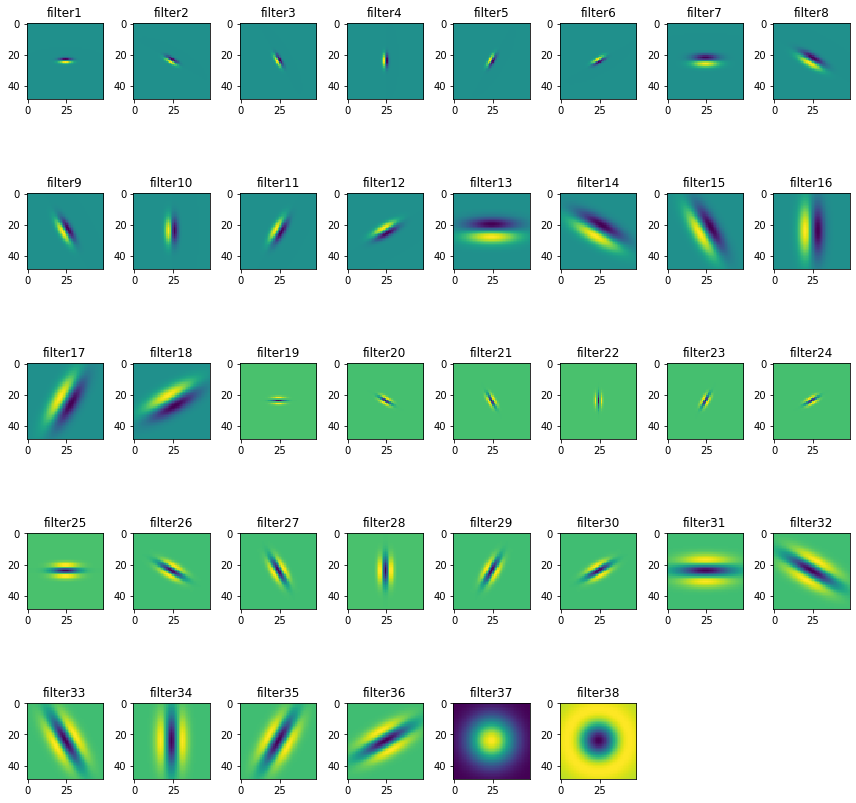

In [4]:
#Display 40 Images
plt.clf()
plt.figure(figsize=(12,12))
filters = loadFilterBank()
for i in range(38):
    plt.subplot(5, 8, i+1)
    plt.imshow(filters[:, :, i])
    plt.title("filter" + str(i+1))
plt.tight_layout()
plt.show()

In [5]:
'''
Inputs:
    - imageStack : list of numpy arrays of dimension N x M x 3 (where N and M can differ between each image)
    - F          : filter bank of dimension 49 x 49 x d where d = # of filters
    - subsample  : subsampling rate to only return a percentage of pixel features
Outputs:
    - features   : 2D numpy array containing the filter responses of imageStack using F
'''
def getFilterResponses(imageStack, F, subsample=0.05):
    features = []
    for image in imageStack:
        N, M, d = image.shape[0], image.shape[1], F.shape[2]
        responses = np.zeros((N,M,d))
        for i in range(d):
            filter = F[:,:,i]
            responses[:,:,i] = scipy.ndimage.convolve(image,filter)
            
        responses = responses.reshape(N*M, d)
        sample_idx = np.random.choice(N*M, int(N*M*subsample), replace=False)
        sampled_responses = responses[sample_idx,:]
        features.append(sampled_responses)
    features = np.concatenate(features, axis=0)
    return features

Now, I will be using k-means to compute texture features. The features themselves will be histograms of **quantized** filter responses of a neighborhood around a pixel. We will walk you through this process with the following steps:

- **createTextons** function. 
    - This function will take an array of gathered **filterResponses** as input.
    - Now, using the KMeans module from scikit-learn, fit it on filterResponses.
    - This will return a trained KMeans (**textons**) to be used in the next function.
    
- **getTextonFeatures** function.
    - It takes as input a **trained** KMeans module (**textons**) from calling createTextons in another cell. 
    - (1) The function will first convolve the input filter bank on an input image. 
        - The result of this will be an **N x M x d** array of responses.
    - (2) Next, create another array of size **N x M** of quantized filter responses for each pixel. To do this:
        - Naively loop through each pixel, but this can be quickly vectorized by doing the following.
        - First, reshape the array from (1) into an array of **NM x d** array. 
        - Next, pass this into the kmeans module to compute their quantized filter responses (i.e. nearest texton). This should be a 1D numpy array containing the new labels. We are essentially mapping the filter responses into a discrete amount of vectors for (3).
        - Finally, reshape the labels back into dimension **N x M**.
    - (3) Next, create **histogram features** of each pixel using their neighborhood's quantized results. Initialize a new array of size **N x M x k**. For each pixel do the following:
        - Using the window_size input, look at surrounding pixels (in a box). (This is completed with inner for loops).
        - Now collect the neighborhood's corresponding quantized labels from step (2). Specifically, collect the number of each quantized label in the neighborhood.
            - I have setup an array of size $k$ for this -- just increment each index based on the neighborhood.
        - Now store this result in the histogram array.
        - **Note:** This is also vectorized (i.e. without the two inner for loops) but be sure to use correct bounds.
        
     - Now just return the array from (3).

In [6]:
from sklearn.cluster import KMeans

In [7]:
'''
Inputs:
    - filterResponses : 2D numpy array containing a set of filter responses from pixels. 
                            - Each row should contain d filter responses where d = size of filter bank used
    - numTextons      : int, specifying the number of cluster centers to find from filterResponses
Outputs:
    - textons         : scikit-learn KMeans module that has been fitted on filterResponses
'''
def createTextons(filterResponses, numTextons=50):
    textons = KMeans(n_clusters=numTextons)# Create KMeans module
    textons.fit(filterResponses)# Now fit on filterResponses 
    
    return textons

In [8]:
'''
Inputs:
    - image        : grayscale image as a numpy array of size N x M
    - textons      : an sklearn.cluster.KMeans module that has been trained on filterResponses
    - F            : filter bank of dimension 49 x 49 x d where d = # of filters
    - window_size  : dimension of square window centered at current pixel to collect histogram information
Outputs:
    - features   : 2D numpy array containing the filter responses of imageStack using F
'''
def getTextonFeatures(image, textons, F, window_size = 7):
    N, M, d = image.shape[0], image.shape[1], F.shape[2]
    k = textons.n_clusters
    
    print("Step 1...")
    # Step (1)
    responses = np.zeros((N,M,d))
    for i in range(d):
        filter = F[:,:,i]
        responses[:,:,i] = scipy.ndimage.convolve(image,filter)
    
    print("Step 2...")
    # Step (2)
    # add in as much code to obtain a final quantized_responses array
    quantized_responses = responses.reshape(N*M, d)
    quantized_responses = textons.predict(quantized_responses)
    quantized_responses = quantized_responses.reshape(N, M)
    
    print("Step 3...")
    # Step (3)
    histograms = np.zeros((N,M,k))
    for i in range(N):
        for j in range(M):
            # current histogram should have k entries where:
            #    i-th element will contain the # of times a quantized centroid occurs
            hist = np.array([0 for i in range(k)])
            
            # go through the neighborhood
            for x in range( max(0, i - window_size // 2), min(N, i + window_size // 2 + 1) ):
                for y in range( max(0, j - window_size // 2), min(M, j + window_size // 2 + 1) ):
                    current_quantized = quantized_responses[x, y]# collect the neighborhood stats
                    hist[current_quantized] = hist[current_quantized] + 1# don't forget to update hist
                    
            # set the pixel's completed histogram
            histograms[i,j] = hist
    
    return histograms

I can now compute the image segmentations. This will be done by another K-means clustering. 

- Complete the createSegmentation function.
    - The input will be **N x M x d** array of features. 
    - Run K-means on this (make sure to first reshape to **NM x d**) using the given k.
    - Now provide the correct label for each feature.
    - **Note:** this is pretty similar to step (2) of getTextonFeatures, except you must train another kmeans module.

In [9]:
'''
Inputs:
    - features     : 3D numpy array containing a set of features for each pixel in an image
    - k            : int, specifying the number of image segments desired
Outputs:
    - segmentation : 2D numpy array containing a label for each pixel based on features
'''
def createSegmentation(features, k=5):
    N,M,d = features.shape
    kmeans = KMeans(n_clusters=k)# create kmeans module
    
    # first fit then predict label of each pixel
    kmeans.fit(features.reshape(N*M, d))
    labels = kmeans.predict(features.reshape(N*M, d))
    
    return labels.reshape(N, M)# return segmentation of size N*M x d

### Part D.

Now to do some visualizations! I pipelined each previous part together.

- (1) Collect the filterResponses from **imageStackGray**.
    - Simply call getFilterResponses and pass in imageStackGray and filter bank F.
    
- (2) Create a textons (Kmeans of responses) module using **createTextons** from data in (1).
    - We suggest using the default value of numTextons=50, but this can be experimented with.
    
Now, **for each image** in imageStack/imageStackGray, do the following (3) to (5) + Visualizations:


- (3) Take the current image (**grayscale version**) and extract the histogram features from **part C**.
    - I can also experiment with window_size to try and understand how these features change.

- (4) Create the segmentation (**part D**) of textonFeatures from (3).
    - Feel free to adjust the value of $k$ to test.

- (5) In addition, create a **color segmentation** from the original color image.
    - This can be done by simply passing in the color version of this image into createSegmentation.
    - Feel free to adjust the value of $k$
    
Now visualized the following:

- The original color image.

- Texture Segmentation from (4).
    - Make sure to title it with the parameters used (numTextons, window_size and $k$)
    
- Color Segmentation from (5).
    - Make sure to title it with the value of $k$ used.

In [10]:
imageStack = loadImages(grayscale=False)
imageStackGray = loadImages(grayscale=True)

In [11]:
F = loadFilterBank()
FilterResponses = getFilterResponses(imageStackGray, F)

In [12]:
textons = createTextons(FilterResponses)

Step 1...
Step 2...
Step 3...


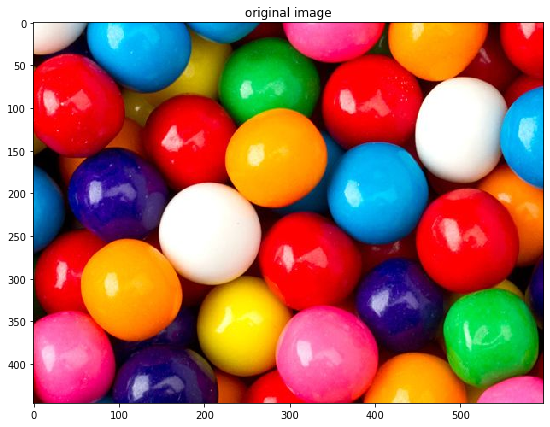

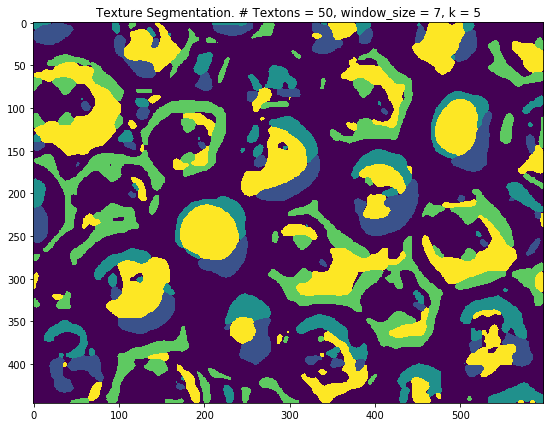

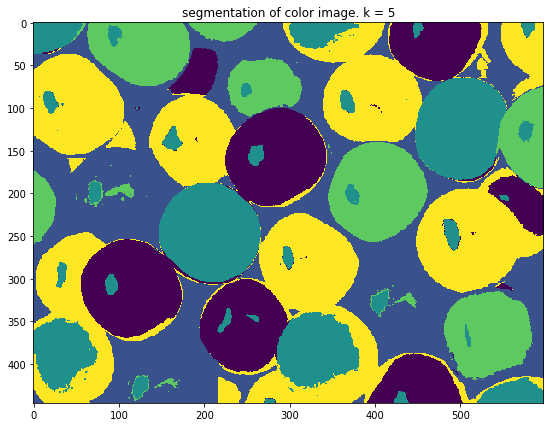

Step 1...
Step 2...
Step 3...


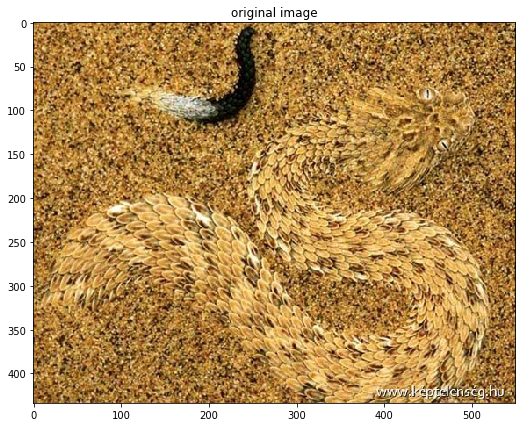

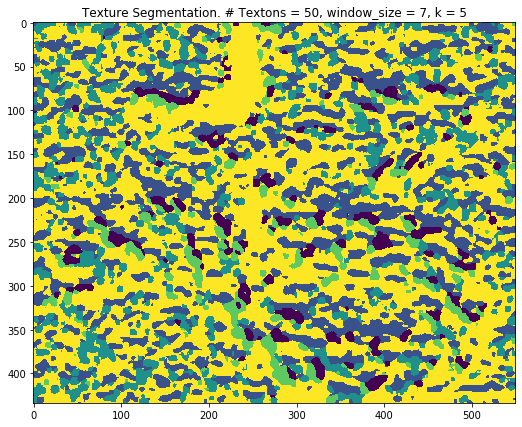

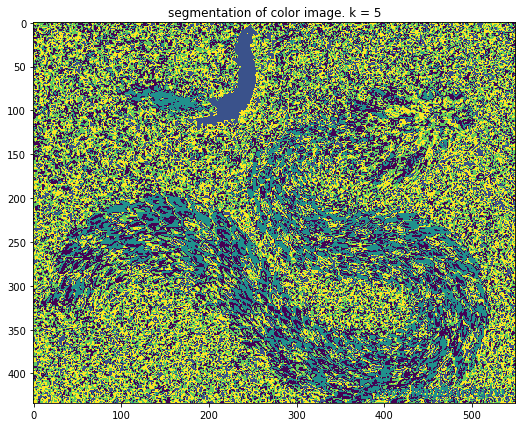

Step 1...
Step 2...
Step 3...


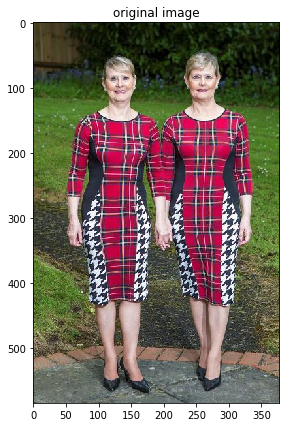

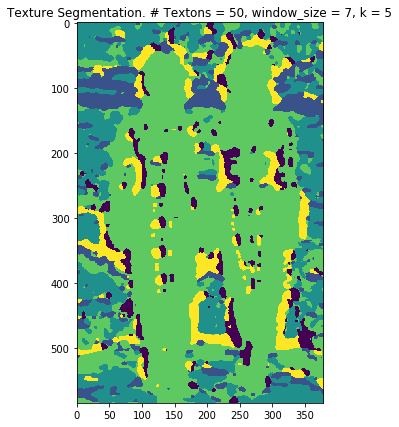

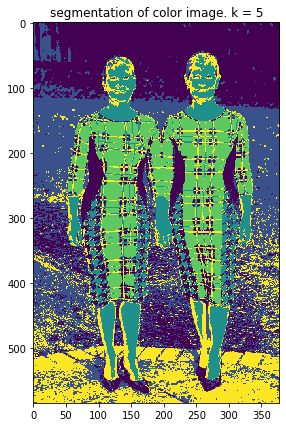

In [13]:
for i in range(3):
    image = imageStack[i]
    imageGray = imageStackGray[i]
    hist = getTextonFeatures(imageGray, textons, F)
    seg = createSegmentation(hist)
    color_seg = createSegmentation(image)
    plt.imshow(image)
    plt.title("original image")
    plt.show()
    plt.imshow(seg)
    plt.title("Texture Segmentation. # Textons = 50, window_size = 7, k = 5")
    plt.show()
    plt.imshow(color_seg)
    plt.title("segmentation of color image. k = 5")
    plt.show()